# 分析思路梳理：

一、基于用户的数据进行聚类
- 1、数据的读取

- 2、数据的探索（目的是为数据预处理做准备）

- 3、数据的预处理（变量的选择、缺失值、异常值、数据类型、标准化处理）

- 4、模型的搭建（确定最优K值-聚类）

- 5、依据模型划分用户群

二、基于用户聚类的结果进行个性化推荐
将用户没有购买过的商品，同一类群中其他用户又都喜欢的，推荐给用户：
- 1、用户没买过的商品信息列表【用户-商品（notbuy）】
- 2、【用户-商品（notbuy）】匹配用户类群【用户-商品（notbuy）-类群】
- 3、定义喜欢（用户对商品的购买次数表示喜好度），构建用户对商品的喜好度【用户-商品-喜好度】
- 4、【用户-商品-喜好度】匹配用户类群【用户-商品-喜好度-类群】
- 5、同一类群中的用户对同一种商品的喜好度进行聚合，得到，用户类群对每一个商品的喜好度【类群-商品-平均喜好度】
- 6、将2与5进行合并（商品-类群），得到【用户-商品（notbuy）-类群-类群平均喜好度】
- 7、对用户进行分组排序，推荐

三、导出结果

导入库和文件位置

In [1]:
import numpy as np
import pandas as pd 

In [2]:
import os
os.chdir(r'E:\Data analysis\CDA\learning\0、python自己练习\6、机器学习\data\推荐系统')

# 基于用户的数据进行聚类

## 读取数据

In [86]:
df_order = pd.read_csv("orders.csv")                          #读取订单数据
df_item = pd.read_csv("Items_orders.csv")                     #读取商品交易数据
df_atrr = pd.read_csv("Items_attribute.csv",encoding='gbk')   #读取商品属性数据

In [4]:
pd.set_option('max_columns',200)    #尽量展示所有列信息

## 数据的探索（目的是为数据预处理做准备）

### 先观察三个表之间的关联性

In [5]:
df_order.head(2)  #查看表数据

,订单编号,买家会员名,买家支付宝账号,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,订单状态,买家留言,收货人姓名,收货地址,运送方式,联系电话,联系手机,订单创建时间,订单付款时间,宝贝标题,宝贝种类,物流单号,物流公司,订单备注,宝贝总数量,店铺Id,店铺名称,订单关闭原因,卖家服务费,买家服务费,发票抬头,是否手机订单,分阶段订单信息,特权订金订单id,是否上传合同照片,是否上传小票,是否代付,定金排名,修改后的sku,修改后的收货地址,异常信息,天猫卡券抵扣,集分宝抵扣,是否是O2O交易,退款金额,预约门店
0,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,交易成功,NaN,33,广东省 广州市 越秀区 华乐街道环市东路华侨新村光明路28号3a楼（即原文化假日酒店，后易名...,快递,NaN,AC5CCC66557,2017/5/30 23:18,2017/5/30 23:18,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家，特价5号AA普通干电池 电动玩具...,5,No:3330622150731,申通快递,NaN,59,0,0,订单未关闭,0,0元,NaN,NaN,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,24270488269081200,2163,AC870BA5860,15.70,5.0,0,20.70,0,20.70,0,交易成功,NaN,1532,江西省 九江市 浔阳区 甘棠街道浔阳东路108号儿童保健康复中心亲子园(332000),快递,NaN,AC870BA5860,2017/5/30 23:08,2017/5/30 23:08,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发，创意新款回力小车惯性坦克 军事...,2,No:71157010281123,百世快递,NaN,2,0,0,订单未关闭,0,0元,NaN,手机订单,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [6]:
df_order.shape,np.unique(df_order.订单编号).shape  #可以看出没有重复数据

((3989, 46), (3989,))

In [8]:
df_item.head()     #查看表数据

,订单编号,标题,价格,购买数量,外部系统编号,商品属性,套餐信息,备注,订单状态,商家编码
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,WY013-2SZD0426,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426
1,21407300627014900,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00,20,HT-5H0094,NaN,NaN,NaN,交易成功,HT-5H0094
2,21407300627014900,大号泡泡棒沙滩小铲子工具泡泡枪公园吹泡泡户外亲子游戏玩具热卖,1.20,16,GC018005,NaN,NaN,NaN,交易成功,GC018005
3,21407300627014900,特价正品7号电池儿童电动玩具电源配件 厂家直销1元4节地摊货批发,1.00,10,HT-7H0093,NaN,NaN,NaN,交易成功,HT-7H0093
4,21407300627014900,儿童沙滩玩具水枪 宝宝玩水玩具户外洗澡游泳漂流戏大号水枪批发,6.79,1,GC080003,套餐类型：标准配置;颜色分类：33000蓝色水枪,NaN,NaN,交易成功,GC080003


In [9]:
df_item.shape,np.unique(df_item.订单编号).shape  
#订单编号去重后与df_order的行数一致
#结合数据，我们可以肯定df_item是订单明细表，df_order是订单表，两个表需要合并成一张表

((21897, 10), (3989,))

In [10]:
df_atrr.head()        #查看表数据

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.90,塑胶玩具,"3岁,4岁,5岁,6岁",3
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.90,其它玩具,"3岁,4岁,5岁,6岁",3
2,35722000205,创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发,1.65,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁",3
3,550659732532,新款创意六一儿童节礼物音乐投影电动枪夜市地摊货源批发男孩玩具,9.90,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁",3
4,531877266868,发条玩具批发上链卡通动物青蛙儿童礼物宝宝玩具经典80后益智地摊,1.85,其它玩具,"3岁,4岁",3


In [11]:
df_atrr.shape,np.unique(df_atrr.宝贝ID).shape   #可以看出没有重复数据
#和df_item表对照看，这张表是商品信息表。
#需要和df_item表合并，把商品属性信息补充到df_item表中
#应该用宝贝ID作为连接字段，因df_item表中无宝贝ID字段;只有标题是共同字段；所以我们考虑用标题作为连接字段

((288, 6), (288,))

In [12]:
np.unique(df_atrr.标题).shape,np.unique(df_item.标题).shape 
#发现df_item表中有部分标题在df_atrr中没有

((288,), (327,))

### 检查导入的列名是否需要预处理

In [13]:
df_atrr.columns

Index(['宝贝ID', '标题', '价格', '玩具类型', '适用年龄', '品牌'], dtype='object')

In [14]:
df_item.columns

Index(['订单编号', '标题', '价格', '购买数量', '外部系统编号', '商品属性', '套餐信息', '备注', '订单状态',
       '商家编码'],
      dtype='object')

In [15]:
df_order.columns
#发现部分列名中带有空格

Index(['订单编号', '买家会员名', '买家支付宝账号', '买家应付货款', '买家应付邮费', '买家支付积分', '总金额', '返点积分',
       '买家实际支付金额', '买家实际支付积分', '订单状态', '买家留言', '收货人姓名', '收货地址', '运送方式',
       '联系电话 ', '联系手机', '订单创建时间', '订单付款时间 ', '宝贝标题 ', '宝贝种类', '物流单号 ', '物流公司',
       '订单备注', '宝贝总数量', '店铺Id', '店铺名称', '订单关闭原因', '卖家服务费', '买家服务费', '发票抬头',
       '是否手机订单', '分阶段订单信息', '特权订金订单id', '是否上传合同照片', '是否上传小票', '是否代付', '定金排名',
       '修改后的sku', '修改后的收货地址', '异常信息', '天猫卡券抵扣', '集分宝抵扣', '是否是O2O交易', '退款金额',
       '预约门店'],
      dtype='object')

In [19]:
df_order.宝贝标题    #进一步验证df_order表的列名存在空格

AttributeError: 'DataFrame' object has no attribute '宝贝标题'

### 处理列名中的空格

In [87]:
for df in [df_order,df_atrr,df_item]:
    df.columns=df.columns.map(lambda x:x.strip())
#把所有表列名中的空格去除

In [22]:
df_order.宝贝标题    #说明空格去除干净

0       发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家，特价5号AA普通干电池 电动玩具...
1       创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发，创意新款回力小车惯性坦克 军事...
2                           创意恐龙玩具卡装仿真恐龙模型小孩礼物宝宝玩具地摊货批发免邮
3                          创意新款发光翅膀背带儿童演出服装天使蝴蝶翅膀地摊货源玩具批发
4                          新品 儿童玩具四驱车男孩玩具车四驱赛车玩具电动车地摊货源批发
5       创意儿童发光刀玩具刀闪光刀剑男生礼物义乌货源地摊玩具批发免邮，新奇创意炫彩飞碟枪飞盘射击枪 ...
6       儿童玩具车卡通惯性工程车宝宝礼物小车男孩创意新奇地摊货源批发，创意音乐电动发光卡通仿真电锯儿...
7       特价5号AA普通干电池 电动玩具配件 厂家直销批，正版电动泡泡枪儿童卡通动物吹泡泡机全自动玩...
8                          创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发
9       儿童地摊小玩具批发经典创意幼儿园礼物100只装竹蜻蜓飞天小玩意，2017新款儿童水枪玩具3岁...
10      创意拉线工程车3款新奇特惯性滑行小车儿童玩具礼物地摊货源批发，创意大号惯性工程车挖土机挖掘机...
11      创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发，创意新款回力小车惯性坦克 军事...
12      卡通动物彩虹圈创意弹簧圈叠叠乐3-6岁儿童发光玩具地摊货源批发，惯性玩具车大巴卡通玩具车公交...
13                        遥控坦克车越野车玩具军事模型可充电动汽车大炮儿童男孩3-6周岁
14                         特价创意变形大号套装模型发光礼物地摊货源义乌热卖儿童玩具批发
15      创意新款发光翅膀背带儿童演出服装天使蝴蝶翅膀地摊货源玩具批发，创意新款发光翅膀背带儿童演出服...
16                         特价创意变形大号套装模型发光礼物地摊货源义乌热卖儿童玩具批发
17            

In [23]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 46 columns):
订单编号        3989 non-null int64
买家会员名       3989 non-null int64
买家支付宝账号     3988 non-null object
买家应付货款      3989 non-null float64
买家应付邮费      3989 non-null float64
买家支付积分      3989 non-null int64
总金额         3989 non-null float64
返点积分        3989 non-null int64
买家实际支付金额    3989 non-null float64
买家实际支付积分    3989 non-null int64
订单状态        3989 non-null object
买家留言        384 non-null object
收货人姓名       3989 non-null int64
收货地址        3989 non-null object
运送方式        3989 non-null object
联系电话        142 non-null object
联系手机        3986 non-null object
订单创建时间      3989 non-null object
订单付款时间      3989 non-null object
宝贝标题        3989 non-null object
宝贝种类        3989 non-null int64
物流单号        3988 non-null object
物流公司        3988 non-null object
订单备注        460 non-null object
宝贝总数量       3989 non-null int64
店铺Id        3989 non-null int64
店铺名称        3989 non-null int64
订单关闭原因     

In [24]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21897 entries, 0 to 21896
Data columns (total 10 columns):
订单编号      21897 non-null int64
标题        21897 non-null object
价格        21897 non-null float64
购买数量      21897 non-null int64
外部系统编号    21897 non-null object
商品属性      12636 non-null object
套餐信息      0 non-null float64
备注        130 non-null object
订单状态      21897 non-null object
商家编码      21897 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 1.7+ MB


In [25]:
df_atrr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
宝贝ID    288 non-null int64
标题      288 non-null object
价格      288 non-null float64
玩具类型    252 non-null object
适用年龄    284 non-null object
品牌      288 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 13.6+ KB


## 基于业务评估对字段进行选择

### 探索df_order表

In [26]:
#先看联系电话和联系手机特征
df_order[df_order.联系电话.notnull()][['联系电话','联系手机']]
#从数据上看，不能给我们提供有用的信息，可以考虑删除

,联系电话,联系手机
32,'010-58758375,A56AA8980CB
41,'010-63036426,AC8A0ACD009
73,'182217-1822177212,A8BBA77BAB6
88,'0760-23860692,NaN
98,'0438-6180034,AC9DC878DA7
156,'0593-2082566,ACCB895CA77
198,'0663-2558099,A5975A7A8B8
201,'0771-8536777,A8577AB9586
210,'0535-1510657-4707,A5A0657D707
250,'0793-1507933137,A5079CCAC7D


In [27]:
(df_order.总金额==df_order.买家实际支付金额).value_counts()
#查看总金额是否与买家实际支付金额一致
#可以看出大部分数据是一致的，此时我们可以考虑把总金额特征删除
#从结果看，有46条记录不一致。为什么不一致？我们进一步探索

True     3943
False      46
dtype: int64

In [28]:
df_order[df_order.总金额!=df_order.买家实际支付金额].head()
#我们发现不一致的是因为退款金额的产生。
#为什么产生这种现象？
#原因有可能是用户在付费时使用优惠券或出现退款现象或者商家人工让利

,订单编号,买家会员名,买家支付宝账号,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,订单状态,买家留言,收货人姓名,收货地址,运送方式,联系电话,联系手机,订单创建时间,订单付款时间,宝贝标题,宝贝种类,物流单号,物流公司,订单备注,宝贝总数量,店铺Id,店铺名称,订单关闭原因,卖家服务费,买家服务费,发票抬头,是否手机订单,分阶段订单信息,特权订金订单id,是否上传合同照片,是否上传小票,是否代付,定金排名,修改后的sku,修改后的收货地址,异常信息,天猫卡券抵扣,集分宝抵扣,是否是O2O交易,退款金额,预约门店
112,21072763406286400,1803,A77BB74B7B0,107.08,0.0,0,107.08,0,104.10,0,交易成功,NaN,463,广东省 佛山市 高明区 更合万和电气(528500),快递,NaN,A77BB7DB7B0,2017/5/30 0:08,2017/5/30 10:14,创意发条玩具上链火车头发条3岁宝宝益智儿童玩具批发 地摊货源，创意恐龙玩具卡装仿真恐龙模型小...,13,No:3330572900905,申通快递,'发申通 送一个小气筒,42,0,0,订单未关闭,0,0元,NaN,手机订单,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.98,NaN
228,23794310267368000,466,A5766C68B85,75.50,0.0,0,75.50,0,59.10,0,交易成功,NaN,3028,广东省 广州市 萝岗区 永和街道广州市萝岗永和开发区横迳5街日盛百货(510530),快递,NaN,A5766C68B85,2017/5/29 1:00,2017/5/29 1:00,创意音乐电动发光卡通仿真电锯儿童礼物地摊3-6岁小玩具货源批发，特价5号AA普通干电池 电动...,10,No:3330529398922,申通快递,NaN,16,0,0,订单未关闭,0,0元,NaN,手机订单,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.40,NaN
470,23300528991848400,2672,A5C8AAA0AA0,91.78,0.0,0,91.78,0,52.45,0,交易成功,NaN,1845,浙江省 金华市 婺城区 城北街道九章路48号西单元501室(321051),快递,NaN,ACC5579DDCC,2017/5/27 9:27,2017/5/27 9:27,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发，创意万向电动音乐车发光儿童汽车...,10,No:3330370672007,申通快递,'地址：杭州市江干区丁桥镇后珠家苑东区3幢2单元201室 童云 13732205129,38,0,0,订单未关闭,0,0元,NaN,手机订单,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.33,NaN
540,23186468899456700,1407,A564BB7678C,96.47,0.0,0,96.47,0,20.88,0,交易成功,NaN,2831,辽宁省 朝阳市 双塔区 红旗街道黄河路三段2#万达广场一楼1F_05佐卡伊柜组(122000),快递,NaN,A56DBB7678C,2017/5/26 18:41,2017/5/26 18:41,特价发条玩具会跑会跳创意上链发条玩具动物儿童好玩的地摊货批发，特价发条玩具会跑会跳创意上链发...,23,No:3330340209741,申通快递,NaN,41,0,0,订单未关闭,0,0元,NaN,手机订单,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.59,NaN
563,23157190921251600,2319,AC67BBA8ACB,56.15,0.0,0,56.15,0,53.64,0,交易成功,NaN,2654,江西省 南昌市 湾里区 站前街道东方红老湾里一中宿舍楼旁前150米大力神洗车店三楼收(330...,快递,NaN,AC67BBA8ACB,2017/5/26 15:30,2017/5/26 15:30,热卖儿童创意玩具超人卡装模型生日礼物 义乌玩具批地摊货源，六一新品恐龙玩具模型回力小车迷你玩...,7,No:71157004659119,百世快递,NaN,8,0,0,订单未关闭,0,0元,NaN,手机订单,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.51,NaN


In [30]:
df_order[df_order.总金额!=df_order.买家实际支付金额][['总金额','集分宝抵扣','买家实际支付金额','退款金额']]
#为什么会出现这种情况，还需要跟退货清单进行核对确认
#因我们没有数据证明退货金额是由用户不满意退货产生的，总金额和买家实际支付金额两个字段可以考虑舍弃其一

,总金额,集分宝抵扣,买家实际支付金额,退款金额
112,107.08,NaN,104.10,2.98
228,75.50,NaN,59.10,16.40
470,91.78,NaN,52.45,39.33
540,96.47,NaN,20.88,75.59
563,56.15,NaN,53.64,2.51
595,195.00,NaN,120.90,74.10
599,13.90,NaN,0.00,13.90
782,169.28,NaN,84.04,85.24
799,119.57,NaN,113.73,5.84
1080,36.80,NaN,35.21,1.59


In [88]:
#基于业务对字段进行评估
col1 = ['买家支付宝账号', '买家应付货款', '买家应付邮费', '买家支付积分', '总金额', '返点积分', 
        '运送方式', '联系电话', '联系手机', '物流单号', '物流公司', '店铺Id', '店铺名称','退款金额']
col1
#这些字段对我们本次分析没有影响，可以删除

['买家支付宝账号',
 '买家应付货款',
 '买家应付邮费',
 '买家支付积分',
 '总金额',
 '返点积分',
 '运送方式',
 '联系电话',
 '联系手机',
 '物流单号',
 '物流公司',
 '店铺Id',
 '店铺名称',
 '退款金额']

In [89]:
df_order_d1=df_order.drop(col1,axis=1)
df_order_d1.head(2)

,订单编号,买家会员名,买家实际支付金额,买家实际支付积分,订单状态,买家留言,收货人姓名,收货地址,订单创建时间,订单付款时间,宝贝标题,宝贝种类,订单备注,宝贝总数量,订单关闭原因,卖家服务费,买家服务费,发票抬头,是否手机订单,分阶段订单信息,特权订金订单id,是否上传合同照片,是否上传小票,是否代付,定金排名,修改后的sku,修改后的收货地址,异常信息,天猫卡券抵扣,集分宝抵扣,是否是O2O交易,预约门店
0,21407300627014900,1425,58.51,0,交易成功,NaN,33,广东省 广州市 越秀区 华乐街道环市东路华侨新村光明路28号3a楼（即原文化假日酒店，后易名...,2017/5/30 23:18,2017/5/30 23:18,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家，特价5号AA普通干电池 电动玩具...,5,NaN,59,订单未关闭,0,0元,NaN,NaN,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24270488269081200,2163,20.70,0,交易成功,NaN,1532,江西省 九江市 浔阳区 甘棠街道浔阳东路108号儿童保健康复中心亲子园(332000),2017/5/30 23:08,2017/5/30 23:08,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发，创意新款回力小车惯性坦克 军事...,2,NaN,2,订单未关闭,0,0元,NaN,手机订单,NaN,NaN,否,否,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_order_d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 32 columns):
订单编号        3989 non-null int64
买家会员名       3989 non-null int64
买家实际支付金额    3989 non-null float64
买家实际支付积分    3989 non-null int64
订单状态        3989 non-null object
买家留言        384 non-null object
收货人姓名       3989 non-null int64
收货地址        3989 non-null object
订单创建时间      3989 non-null object
订单付款时间      3989 non-null object
宝贝标题        3989 non-null object
宝贝种类        3989 non-null int64
订单备注        460 non-null object
宝贝总数量       3989 non-null int64
订单关闭原因      3989 non-null object
卖家服务费       3989 non-null int64
买家服务费       3989 non-null object
发票抬头        0 non-null float64
是否手机订单      3728 non-null object
分阶段订单信息     0 non-null float64
特权订金订单id    0 non-null float64
是否上传合同照片    3989 non-null object
是否上传小票      3989 non-null object
是否代付        3989 non-null object
定金排名        0 non-null float64
修改后的sku     0 non-null float64
修改后的收货地址    61 non-null object
异常信息        0 non-null

####  针对缺失值过多的字段进行分析

In [34]:
#找到缺失值大于80%的字段进行分析
df_order_d1.isnull().mean()>0.8
#df_order_d1.isnull().sum()/df_order_d1.shape[0]#这两者相同

订单编号        False
买家会员名       False
买家实际支付金额    False
买家实际支付积分    False
订单状态        False
买家留言         True
收货人姓名       False
收货地址        False
订单创建时间      False
订单付款时间      False
宝贝标题        False
宝贝种类        False
订单备注         True
宝贝总数量       False
订单关闭原因      False
卖家服务费       False
买家服务费       False
发票抬头         True
是否手机订单      False
分阶段订单信息      True
特权订金订单id     True
是否上传合同照片    False
是否上传小票      False
是否代付        False
定金排名         True
修改后的sku      True
修改后的收货地址     True
异常信息         True
天猫卡券抵扣       True
集分宝抵扣        True
是否是O2O交易     True
预约门店         True
dtype: bool

In [90]:
for column in df_order_d1.columns:
    if df_order_d1[column].isnull().mean()>0.8:
        print(column)
        print(df_order_d1[column].isnull().mean())
        #print(df_order_d1[column].value_counts())
        print('---------------------------------')

买家留言
0.9037352719979945
---------------------------------
订单备注
0.8846828779142643
---------------------------------
发票抬头
1.0
---------------------------------
分阶段订单信息
1.0
---------------------------------
特权订金订单id
1.0
---------------------------------
定金排名
1.0
---------------------------------
修改后的sku
1.0
---------------------------------
修改后的收货地址
0.9847079468538481
---------------------------------
异常信息
1.0
---------------------------------
天猫卡券抵扣
1.0
---------------------------------
集分宝抵扣
0.9969917272499373
---------------------------------
是否是O2O交易
1.0
---------------------------------
预约门店
1.0
---------------------------------


In [36]:
df_order_d1['集分宝抵扣'].value_counts()

#这个字段也是无用的，可以考虑删除

1294.0    1
103.0     1
647.0     1
196.0     1
574.0     1
712.0     1
2291.0    1
22.0      1
13.0      1
54.0      1
14.0      1
218.0     1
Name: 集分宝抵扣, dtype: int64

In [91]:
#需要做客户区域分群，我们可以按照这个方式处理地址数据，不过用户常驻地的地址才有意义
#观察发现收获地址是无缺失值的，而修改后的地址有缺失，说明有部分用户的修改后的地址为最准确的数据
#将修改后的地址更新到收货地址中去
#使用填充缺失值方法
# df_order_d1['修改后的收货地址']=df_order_d1['修改后的收货地址'].fillna(df_order_d1['收货地址'],axis=0)
# df_order_d1['修改后的收货地址'].isnull().mean()
# df_order_d1.drop(columns='收货地址',axis=1,inplace=True)
# df_order_d1.rename(columns={'修改后的收货地址':'收货地址'},inplace=True)

#我们选择删除地址数据
del df_order_d1['收货地址']
del df_order_d1['修改后的收货地址']

In [92]:
#把其余缺失值多余80%的数据删除
isna_columns=df_order_d1.isnull().mean()>0.8
df_order_d1.drop(columns=isna_columns[isna_columns].index.tolist(),axis=1,inplace=True)

In [93]:
df_order_d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 18 columns):
订单编号        3989 non-null int64
买家会员名       3989 non-null int64
买家实际支付金额    3989 non-null float64
买家实际支付积分    3989 non-null int64
订单状态        3989 non-null object
收货人姓名       3989 non-null int64
订单创建时间      3989 non-null object
订单付款时间      3989 non-null object
宝贝标题        3989 non-null object
宝贝种类        3989 non-null int64
宝贝总数量       3989 non-null int64
订单关闭原因      3989 non-null object
卖家服务费       3989 non-null int64
买家服务费       3989 non-null object
是否手机订单      3728 non-null object
是否上传合同照片    3989 non-null object
是否上传小票      3989 non-null object
是否代付        3989 non-null object
dtypes: float64(1), int64(7), object(10)
memory usage: 561.0+ KB


#### 继续探索剩余字段

In [40]:
df_order_d1.买家实际支付金额.value_counts()

12.90     124
11.90      58
34.90      44
20.90      33
13.90      28
10.90      23
14.90      21
12.80      20
24.90      19
16.80      19
21.90      18
20.80      16
9.90       16
58.00      15
18.80      15
12.75      14
54.00      14
44.90      13
38.80      13
59.00      13
16.70      12
17.90      11
24.80      11
100.00     10
7.90       10
14.80      10
18.90      10
90.00      10
25.70      10
44.00       9
         ... 
62.24       1
56.98       1
420.60      1
11.45       1
72.20       1
64.68       1
36.15       1
53.14       1
165.32      1
59.36       1
87.91       1
46.87       1
99.60       1
30.26       1
26.77       1
92.79       1
33.37       1
161.60      1
97.84       1
53.53       1
83.11       1
69.87       1
24.33       1
43.34       1
31.35       1
46.20       1
26.97       1
83.42       1
56.90       1
185.41      1
Name: 买家实际支付金额, Length: 2451, dtype: int64

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False

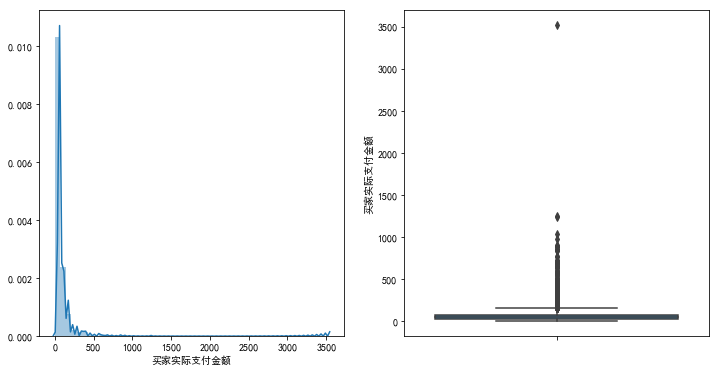

In [42]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_order_d1.买家实际支付金额,ax=ax1)
sns.boxplot(y='买家实际支付金额',data=df_order_d1,ax=ax2)
plt.show()
#从两张图看出，存在异常值

In [43]:
a=pd.DataFrame(df_order_d1.买家实际支付金额.describe()).T
IQR=a['75%']-a['25%']
extreme_outlier=IQR*1.5+a['75%']
mild_outlier=a['25%']-IQR*1.5
print(a.T)
print('上限界：',extreme_outlier)
print('下限界：',mild_outlier)

          买家实际支付金额
count  3989.000000
mean     72.613673
std     112.279791
min       0.000000
25%      22.080000
50%      52.320000
75%      77.000000
max    3521.000000
上限界： 买家实际支付金额    159.38
dtype: float64
下限界： 买家实际支付金额   -60.3
dtype: float64


In [44]:
df_order_d1[(df_order_d1.买家实际支付金额<1500)&(df_order_d1.买家实际支付金额>159.5)]['买家实际支付金额'].value_counts().shape

(284,)

In [45]:
df_order_d1[(df_order_d1.买家实际支付金额<1500)&(df_order_d1.买家实际支付金额>1200)]['买家实际支付金额'].value_counts()

1245.0    1
1250.0    1
Name: 买家实际支付金额, dtype: int64

In [46]:
df_order_d1[df_order_d1.买家实际支付金额>1500]['买家实际支付金额'].value_counts()

#对于该字段的异常值处理方案
#1、1200以下的不予处理。数据量大且连续，自成一类特征
#2、120以上的就两条记录，考虑聚类效果，予以删除

3521.0    1
Name: 买家实际支付金额, dtype: int64

In [94]:
df_order_d2=df_order_d1[df_order_d1.买家实际支付金额<1200]
#删除买家实际支付金额的异常值数据

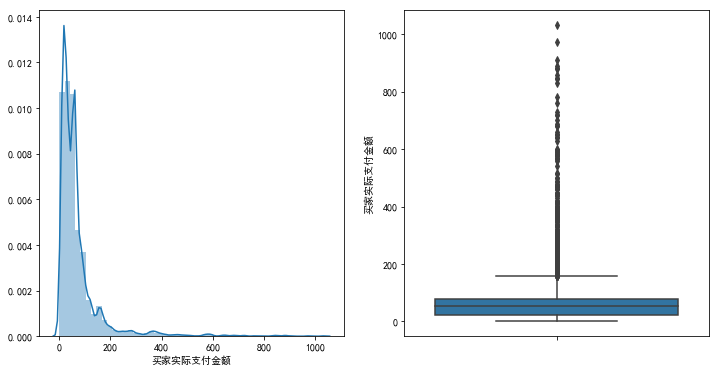

In [95]:
#再次看看我们把异常值删除后的效果图
f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_order_d2.买家实际支付金额,ax=ax1)
sns.boxplot(y='买家实际支付金额',data=df_order_d2,ax=ax2)
plt.show()
#从图形看，获得了我们想要的数据

In [51]:
df_order_d2.shape,df_order_d1.shape  #删除了3个异常值

((3986, 19), (3989, 19))

In [53]:
#探索买家实际支付积分特征数据
df_order_d2.买家实际支付积分.value_counts()

#可以看出，这个特征的值只有一个；只包含一种信息的特征，对我们做聚类没有意义。
#我们选择把所有这种特征删除

0    3986
Name: 买家实际支付积分, dtype: int64

In [96]:
#删除只表达一种信息的特征
for column in df_order_d2.columns:
    cate_count=df_order_d2[column].value_counts().shape[0]    
    #或者cate_count=len(df_order_d2[column].value_counts())
    #或者cate_count=len(set(df_order_d2[column][df_order_d2[column].notnull()].tolist()))
    if cate_count==1:
        del df_order_d2[column]

In [97]:
#探索收货人姓名特征
df_order_d2.groupby(by=['买家会员名','收货人姓名']).count()['订单编号'].value_counts()

#收货人姓名大部分还是用户本人，我们可以删除收货人姓名特征

1     3076
2      266
3       55
4       20
5        8
7        5
6        4
16       1
10       1
8        1
Name: 订单编号, dtype: int64

In [98]:
del df_order_d2['收货人姓名'] #删除收货人姓名特征

In [57]:
df_order_d2[df_order_d2.订单创建时间!=df_order_d2.订单付款时间].shape

(2041, 9)

In [58]:
df_order_d2[df_order_d2.订单创建时间==df_order_d2.订单付款时间].shape

(1945, 9)

In [59]:
df_order_d2.订单创建时间.value_counts()

2017/5/9 8:54      4
2017/5/8 20:32     3
2017/5/14 12:51    3
2017/5/8 10:02     3
2017/5/2 8:55      3
2017/5/15 23:00    3
2017/5/12 12:41    3
2017/5/1 17:19     3
2017/5/14 13:03    3
2017/5/25 22:50    3
2017/5/22 17:16    3
2017/5/20 15:17    3
2017/5/26 16:00    3
2017/5/27 11:54    3
2017/5/25 22:22    2
2017/5/1 18:25     2
2017/5/20 10:06    2
2017/5/12 14:25    2
2017/5/29 22:22    2
2017/5/16 13:04    2
2017/5/17 14:16    2
2017/5/24 15:06    2
2017/5/23 11:21    2
2017/5/2 15:14     2
2017/5/23 8:54     2
2017/5/1 15:19     2
2017/5/2 8:51      2
2017/5/24 16:16    2
2017/5/27 14:41    2
2017/5/16 14:43    2
                  ..
2017/5/23 20:16    1
2017/5/25 7:45     1
2017/5/11 22:57    1
2017/5/24 13:09    1
2017/5/13 7:51     1
2017/5/26 8:17     1
2017/5/11 21:03    1
2017/5/27 22:37    1
2017/5/12 10:41    1
2017/5/17 17:25    1
2017/5/12 8:12     1
2017/5/1 0:00      1
2017/5/20 21:09    1
2017/5/11 22:32    1
2017/5/6 19:18     1
2017/5/1 11:22     1
2017/5/16 21:

In [99]:
#时间序列数据分析较复杂，对于我们聚类处理没有多大影响，我们选择删除订单创建时间和订单付款时间特征
del df_order_d2['订单创建时间']
del df_order_d2['订单付款时间']

In [61]:
df_order_d2.head(2)

,订单编号,买家会员名,买家实际支付金额,宝贝标题,宝贝种类,宝贝总数量,收货地址
0,21407300627014900,1425,58.51,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家，特价5号AA普通干电池 电动玩具...,5,59,广东省 广州市 越秀区 华乐街道环市东路华侨新村光明路28号3a楼（即原文化假日酒店，后易名...
1,24270488269081200,2163,20.70,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发，创意新款回力小车惯性坦克 军事...,2,2,江西省 九江市 浔阳区 甘棠街道浔阳东路108号儿童保健康复中心亲子园(332000)


In [62]:
df_order_d2.宝贝标题[:3]

0    发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家，特价5号AA普通干电池 电动玩具...
1    创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发，创意新款回力小车惯性坦克 军事...
2                        创意恐龙玩具卡装仿真恐龙模型小孩礼物宝宝玩具地摊货批发免邮
Name: 宝贝标题, dtype: object

In [100]:
#宝贝标题特征中没有我们需要的信息，选择删除；另df_order订单信息中的宝贝标题不准
del df_order_d2['宝贝标题']

In [64]:
df_order_d2.head()

,订单编号,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量,收货地址
0,21407300627014900,1425,58.51,5,59,广东省 广州市 越秀区 华乐街道环市东路华侨新村光明路28号3a楼（即原文化假日酒店，后易名...
1,24270488269081200,2163,20.70,2,2,江西省 九江市 浔阳区 甘棠街道浔阳东路108号儿童保健康复中心亲子园(332000)
2,21402600386365500,375,12.90,1,1,浙江省 宁波市 江东区 新明街道明晨紫月227弄25号401室(315040)
3,21398820349555700,2618,9.81,1,1,湖南省 邵阳市 其它区 湖南省邵阳市双清区铁砂岭小学后面(422000)
4,21446781606162100,2012,28.92,1,8,安徽省 阜阳市 颍东区 新华街道尚武艺术培训中心(236058)


In [101]:
#地址需要做分析可以按照这种方式提取信息
#收货地址特征，我们只需省份
#df_order_d2['收货地址']=df_order_d2['收货地址'].apply(lambda x:x.split()[0])

In [66]:
df_order_d2.head()

,订单编号,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量,收货地址
0,21407300627014900,1425,58.51,5,59,广东省
1,24270488269081200,2163,20.70,2,2,江西省
2,21402600386365500,375,12.90,1,1,浙江省
3,21398820349555700,2618,9.81,1,1,湖南省
4,21446781606162100,2012,28.92,1,8,安徽省


In [67]:
df_order_d2.宝贝种类.value_counts()

1     1528
2      299
3      254
4      244
5      233
6      218
8      157
7      147
9      136
10     121
12      98
11      96
13      72
14      60
15      58
16      39
17      35
18      28
19      25
21      22
20      20
23      14
24      11
22       8
25       7
26       6
27       5
38       5
28       5
29       4
33       4
49       4
36       3
30       3
40       2
37       2
41       2
45       1
32       1
34       1
46       1
48       1
43       1
47       1
31       1
35       1
39       1
50       1
Name: 宝贝种类, dtype: int64

In [68]:
df_order_d2.宝贝种类.value_counts().describe()

count      48.000000
mean       83.041667
std       227.618471
min         1.000000
25%         2.000000
50%         7.500000
75%        78.000000
max      1528.000000
Name: 宝贝种类, dtype: float64

In [69]:
78+(78-2)*1.5

192.0

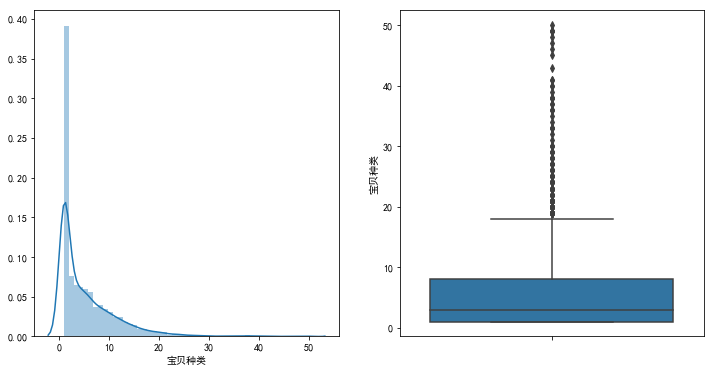

In [102]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_order_d2.宝贝种类,ax=ax1)
sns.boxplot(y='宝贝种类',data=df_order_d2,ax=ax2)
plt.show()

#从数据和图形看，数据分布比较均匀，异常值有意义的不能删除。

In [71]:
df_order_d2.宝贝总数量.describe()

count    3986.000000
mean       23.839940
std        44.951522
min         1.000000
25%         4.000000
50%        10.000000
75%        26.000000
max       820.000000
Name: 宝贝总数量, dtype: float64

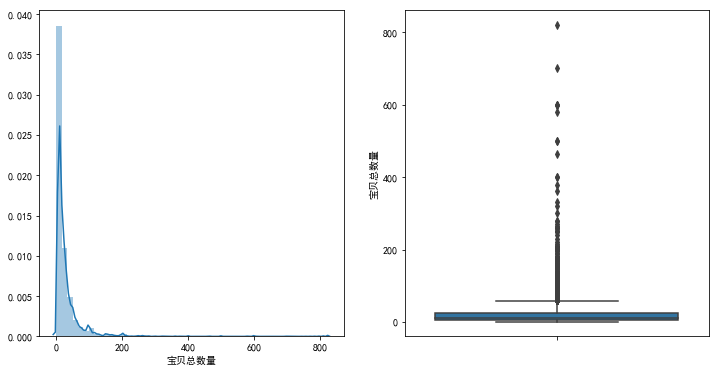

In [103]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_order_d2.宝贝总数量,ax=ax1)
sns.boxplot(y='宝贝总数量',data=df_order_d2,ax=ax2)
plt.show()
#从数据和图形看，出现长尾数据，出现较少的离群数据。我们再细分析删除少量异常值

In [104]:
#为了保证聚类效果，删除数量大于500的数值
df_order_d3=df_order_d2[df_order_d2.宝贝总数量<500]

In [105]:
df_order_d3.head()

,订单编号,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量
0,21407300627014900,1425,58.51,5,59
1,24270488269081200,2163,20.70,2,2
2,21402600386365500,375,12.90,1,1
3,21398820349555700,2618,9.81,1,1
4,21446781606162100,2012,28.92,1,8


In [106]:
df_order_d3.shape,df_order_d2.shape    #删除了8个异常值

((3978, 5), (3986, 5))

In [107]:
df_order_d3.isnull().mean()  


订单编号        0.0
买家会员名       0.0
买家实际支付金额    0.0
宝贝种类        0.0
宝贝总数量       0.0
dtype: float64

In [108]:
np.unique(df_order_d3.买家会员名).shape   #说明有576条订单是用户多次下单

(3402,)

In [109]:
df_order_d3.买家会员名.value_counts()

1631    16
2148    10
2989     9
2926     8
2174     8
943      7
1782     7
327      7
2236     7
908      7
930      7
2263     6
1479     6
1874     6
2471     5
1977     5
1873     5
772      5
1603     5
68       5
3377     5
2270     5
3034     4
1913     4
815      4
2833     4
2278     4
1942     4
884      4
533      4
        ..
954      1
2999     1
950      1
946      1
3039     1
3043     1
3091     1
998      1
1042     1
3087     1
1038     1
3083     1
1034     1
3079     1
1030     1
3075     1
1026     1
3071     1
3067     1
1018     1
3063     1
1014     1
3059     1
1010     1
3055     1
1006     1
3051     1
1002     1
3047     1
0        1
Name: 买家会员名, Length: 3402, dtype: int64

#### 获取用户订单行为数据

In [110]:
user_info1=df_order_d3.groupby(['买家会员名']).mean()
del user_info1['订单编号']
user_info1.reset_index(inplace=True)
user_info1.head()
#我们获得用户订单行为最终数据

,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量
0,0,14.90,1.0,1.0
1,1,37.56,4.0,8.0
2,2,58.50,2.0,15.0
3,3,13.39,2.0,2.0
4,4,30.87,6.0,6.0


In [111]:
user_info1.shape,np.unique(user_info1.买家会员名).shape   #没有重复数据

((3402, 4), (3402,))

### 基于用户交易数据，挖掘用户特征
- 探索df_item表

#### 探索表和特征

In [112]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21897 entries, 0 to 21896
Data columns (total 10 columns):
订单编号      21897 non-null int64
标题        21897 non-null object
价格        21897 non-null float64
购买数量      21897 non-null int64
外部系统编号    21897 non-null object
商品属性      12636 non-null object
套餐信息      0 non-null float64
备注        130 non-null object
订单状态      21897 non-null object
商家编码      21897 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 1.7+ MB


In [113]:
df_order_d3.head()

,订单编号,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量
0,21407300627014900,1425,58.51,5,59
1,24270488269081200,2163,20.70,2,2
2,21402600386365500,375,12.90,1,1
3,21398820349555700,2618,9.81,1,1
4,21446781606162100,2012,28.92,1,8


In [114]:
df_order_d3.shape,np.unique(df_order_d3.订单编号).shape  #没有重复数据

((3978, 5), (3978,))

In [115]:
df_item.head()

,订单编号,标题,价格,购买数量,外部系统编号,商品属性,套餐信息,备注,订单状态,商家编码
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,WY013-2SZD0426,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426
1,21407300627014900,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00,20,HT-5H0094,NaN,NaN,NaN,交易成功,HT-5H0094
2,21407300627014900,大号泡泡棒沙滩小铲子工具泡泡枪公园吹泡泡户外亲子游戏玩具热卖,1.20,16,GC018005,NaN,NaN,NaN,交易成功,GC018005
3,21407300627014900,特价正品7号电池儿童电动玩具电源配件 厂家直销1元4节地摊货批发,1.00,10,HT-7H0093,NaN,NaN,NaN,交易成功,HT-7H0093
4,21407300627014900,儿童沙滩玩具水枪 宝宝玩水玩具户外洗澡游泳漂流戏大号水枪批发,6.79,1,GC080003,套餐类型：标准配置;颜色分类：33000蓝色水枪,NaN,NaN,交易成功,GC080003


In [116]:
df_item.shape, np.unique(df_item.订单编号).shape

((21897, 10), (3989,))

In [117]:
df_item.商品属性.value_counts()

颜色分类：发光翅膀;大小描述：大号                   354
颜色分类：带绳水晶球5.5CM                     282
颜色分类：黑色电动枪A;大小描述：均码                 221
颜色分类：398-13挖掘机                      219
颜色分类：2385新款挖掘机                      196
颜色分类：发条铁皮青蛙                         175
颜色分类：小兔子故事机;大小描述：均码                 160
套餐类型：标准配置;颜色分类：射击水枪                 149
颜色分类：极速陀螺                           146
颜色分类：磁性钓鱼（6条鱼）;大小描述：均码              144
颜色分类：混合战车套装                         136
颜色分类：孔雀开屏变色手指灯                      134
颜色分类：A380飞机;套餐类型：官方标配               132
颜色分类：蜜蜂翻斗车;套餐类型：官方标配                126
颜色分类：802沙滩车                         126
颜色分类：蘑菇电话机                          118
颜色分类：4个装奥特曼;大小描述：均码                 117
颜色分类：平毛倒退狗;大小描述：颜色随机                111
颜色分类：866铲车挖机                        108
颜色分类：拉线警车                           101
颜色分类：小鸭子手推车                         101
颜色分类：不发光翅膀;大小描述：大号                   98
颜色分类：电子小刀                            95
颜色分类：闪光透明星星蝴蝶                        90
颜色分类：鲨鱼小刀                            85


In [118]:
df_item.套餐信息.value_counts()

Series([], Name: 套餐信息, dtype: int64)

In [119]:
df_item.套餐信息.isnull().sum()  #21897=df_item.shape[0]

21897

In [120]:
df_item.备注.value_counts()

邮政                          18
不要放任何发货清单和与产品有关的宣传页。         8
开收据                          2
发邮政                          2
邮政快递                         2
发邮政。                         2
亲开收据                         1
要279个，质量要好，不要漏发了，谢谢！         1
补发一条电动鱼！发申通                  1
开张收据给我                       1
开张收据  需要报销                   1
掌柜，记得补3个球                    1
两个颜色不一样，帮忙开个收据，谢谢            1
开收据:顺儿乐托儿所                   1
老板：请开张收据                     1
请发邮政！                        1
选一个粉色的                       1
收据，广州乐奇积教育咨询有限公司             1
我要深绿色                        1
一个红色一个黄色                     1
3个粉   3个蓝                    1
希望尽快发货，谢谢！                   1
请发顺丰到付                       1
开收据谢谢                        1
多送两个吧！万一有不亮的，孩子们就不够分了！       1
补发赠品                         1
一个蓝色，一个紫色                    1
:发好的                         1
请检查好质量，多送几个尾巴，多送几个孔雀，谢谢      1
发申通                          1
                            ..
要红色！                         1
记得写张收据给我

#### 提取重要信息

In [121]:
#通过查看数据订单编号,标题,价格才是我们想要的数据
df_item_d1=df_item.loc[:,['订单编号','标题','价格']]

In [122]:
df_item_d1.info()  #没有缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21897 entries, 0 to 21896
Data columns (total 3 columns):
订单编号    21897 non-null int64
标题      21897 non-null object
价格      21897 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 513.3+ KB


#### 合并数据

In [123]:
#合并df_order_d3和df_item_d1两个表
item_order=pd.merge(df_order_d3,df_item_d1,on='订单编号',how='left')
item_order.head()

,订单编号,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量,标题,价格
0,21407300627014900,1425,58.51,5,59,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58
1,21407300627014900,1425,58.51,5,59,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00
2,21407300627014900,1425,58.51,5,59,大号泡泡棒沙滩小铲子工具泡泡枪公园吹泡泡户外亲子游戏玩具热卖,1.20
3,21407300627014900,1425,58.51,5,59,特价正品7号电池儿童电动玩具电源配件 厂家直销1元4节地摊货批发,1.00
4,21407300627014900,1425,58.51,5,59,儿童沙滩玩具水枪 宝宝玩水玩具户外洗澡游泳漂流戏大号水枪批发,6.79


In [124]:
item_order.shape

(21847, 7)

In [125]:
item_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21847 entries, 0 to 21846
Data columns (total 7 columns):
订单编号        21847 non-null int64
买家会员名       21847 non-null int64
买家实际支付金额    21847 non-null float64
宝贝种类        21847 non-null int64
宝贝总数量       21847 non-null int64
标题          21847 non-null object
价格          21847 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 1.3+ MB


In [127]:
pd.isna(item_order).mean()  #没有缺失值

订单编号        0.0
买家会员名       0.0
买家实际支付金额    0.0
宝贝种类        0.0
宝贝总数量       0.0
标题          0.0
价格          0.0
dtype: float64

#### 获取用户交易行为数据

In [128]:
#获取用户平均购买商品的单价
user_info2=item_order.groupby(by='买家会员名').mean().reset_index()[['买家会员名','价格']]
user_info2.head()

,买家会员名,价格
0,0,9.900000
1,1,4.957500
2,2,3.725000
3,3,4.520000
4,4,4.651667


In [129]:
np.unique(user_info2.买家会员名).shape,user_info2.shape

((3402,), (3402, 2))

### 基于用户所购买的商品属性特征，挖掘用户特征
- 探索df_atrr表

#### 探索商品重要属性特征

In [131]:
df_atrr.head()

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.90,塑胶玩具,"3岁,4岁,5岁,6岁",3
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.90,其它玩具,"3岁,4岁,5岁,6岁",3
2,35722000205,创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发,1.65,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁",3
3,550659732532,新款创意六一儿童节礼物音乐投影电动枪夜市地摊货源批发男孩玩具,9.90,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁",3
4,531877266868,发条玩具批发上链卡通动物青蛙儿童礼物宝宝玩具经典80后益智地摊,1.85,其它玩具,"3岁,4岁",3


In [132]:
df_atrr.品牌.value_counts()  #现在的用户对品牌的敏感度没有品类的敏感度高，商品同质化现象是一种因素

3     137
2      71
4      14
22     11
0      10
20      8
10      8
14      4
17      3
15      3
9       3
13      2
16      2
7       2
19      2
18      1
1       1
8       1
5       1
6       1
21      1
12      1
11      1
Name: 品牌, dtype: int64

In [133]:
df_atrr.玩具类型.value_counts()

其它玩具       165
塑胶玩具        27
其他          24
电玩具         11
仿真生活家电       9
普通娃娃         5
拼搭积木         3
单杆手推玩具       2
仿真医生玩具       1
发泄           1
娃娃玩具         1
仿真厨房类        1
陀螺           1
仿真房间/家具      1
Name: 玩具类型, dtype: int64

In [134]:
df_atrr.适用年龄.value_counts()

3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁             54
3岁,4岁,5岁,6岁                                          36
3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁                     36
2岁,3岁,4岁,5岁,6岁                                       30
3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁                             19
3岁,4岁,5岁,6岁,7岁,8岁                                    16
3岁,4岁,5岁                                             11
3岁,4岁,5岁,6岁,7岁,8岁,9岁                                 11
3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁                  7
3岁,4岁,5岁,6岁,7岁                                        6
3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁                          5
2岁,3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁           4
12个月,18个月,2岁,3岁,4岁,5岁,6岁                              3
2岁,3岁,4岁,5岁,6岁,7岁,8岁,9岁                               3
2岁,3岁,4岁,5岁                                           3
2岁,3岁,4岁,5岁,6岁,7岁,8岁                                  3
3个月,6个月,12个月,18个月                                     3
2岁,3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁                     

In [135]:
df_atrr.适用年龄.head()

0                                 3岁,4岁,5岁,6岁
1                                 3岁,4岁,5岁,6岁
2            3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁
3    3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁
4                                       3岁,4岁
Name: 适用年龄, dtype: object

In [136]:
df_atrr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
宝贝ID    288 non-null int64
标题      288 non-null object
价格      288 non-null float64
玩具类型    252 non-null object
适用年龄    284 non-null object
品牌      288 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 13.6+ KB


In [137]:
#处理适用年龄缺失值
df_atrr.适用年龄.fillna(value='missing',inplace=True)

In [138]:
#定义一个商品适用年龄的标签结构
#2岁以下不包含2岁，定义为婴儿，包含月
#2岁-4岁定义为幼儿
#5岁-7岁-定义儿童
#8岁以上定义为学生
def addTag(x):
    tag=''
    if '月' in x:
        tag+='婴儿'
    x=x.split(',')
    if '2岁' in x or '3岁' in x or '4岁' in x:
        tag+='幼儿|'
    if '5岁' in x or '6岁' in x or '7岁' in x:
        tag+='儿童|'
    if '8岁' in x or '9岁' in x or '10岁' in x or  '11岁' in x or '12岁' in x or '13岁'in x or '14岁' in x:
        tag+='学生|'
    if 'missing' in x:
        tag+='missing'
    return tag

In [140]:
df_atrr['tag']=df_atrr.适用年龄.apply(addTag)
#通过适用年龄对于各玩具商品划分类别
df_atrr.head()

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌,tag
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.90,塑胶玩具,"3岁,4岁,5岁,6岁",3,幼儿|儿童|
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.90,其它玩具,"3岁,4岁,5岁,6岁",3,幼儿|儿童|
2,35722000205,创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发,1.65,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁",3,幼儿|儿童|学生|
3,550659732532,新款创意六一儿童节礼物音乐投影电动枪夜市地摊货源批发男孩玩具,9.90,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁",3,幼儿|儿童|学生|
4,531877266868,发条玩具批发上链卡通动物青蛙儿童礼物宝宝玩具经典80后益智地摊,1.85,其它玩具,"3岁,4岁",3,幼儿|


In [141]:
#6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁
#儿童|学生
df_atrr[df_atrr.适用年龄=='6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁']
#随机抽样验证数据截取是否正确

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌,tag
45,531145857565,儿童玩具学生魔方三阶百变魔方益智比赛减压玩具地摊货源热卖批发,5.55,塑胶玩具,"6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁",16,儿童|学生|
169,552179640607,异形益智魔方三阶减压魔方金字塔3阶五魔方镜面比赛解压玩具套装,4.99,塑胶玩具,"6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁",16,儿童|学生|


#### 提取重要特征信息

In [143]:
#提取我们需要的标题和tag特征信息
df_atrr_d1=df_atrr.loc[:,['标题','tag']]
df_atrr_d1.head()

,标题,tag
0,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,幼儿|儿童|
1,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,幼儿|儿童|
2,创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发,幼儿|儿童|学生|
3,新款创意六一儿童节礼物音乐投影电动枪夜市地摊货源批发男孩玩具,幼儿|儿童|学生|
4,发条玩具批发上链卡通动物青蛙儿童礼物宝宝玩具经典80后益智地摊,幼儿|


#### 合并数据

In [144]:
df_item_d1.shape,np.unique(df_item_d1.标题).shape

((21897, 3), (327,))

In [145]:
df_atrr_d1.shape,np.unique(df_atrr_d1.标题).shape

((288, 2), (288,))

In [146]:
#将df_atrr_d1表与df_item_d1表合并
item_attr=pd.merge(df_item_d1,df_atrr_d1,on='标题',how='inner')
item_attr.head()
#获得订单商品信息

,订单编号,标题,价格,tag
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,幼儿|儿童|学生|
1,24043728806509300,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,幼儿|儿童|学生|
2,24043728806509300,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.68,幼儿|儿童|学生|
3,20885882368182100,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.68,幼儿|儿童|学生|
4,20885882368182100,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,幼儿|儿童|学生|


In [147]:
item_attr.info()  #无缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19943 entries, 0 to 19942
Data columns (total 4 columns):
订单编号    19943 non-null int64
标题      19943 non-null object
价格      19943 non-null float64
tag     19943 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 779.0+ KB


In [148]:
#删除标题特征
del item_attr['标题']

In [150]:
#将item_attr表和df_order_d3表合并
item_attr_user=pd.merge(df_order_d3,item_attr,on='订单编号',how='left')
item_attr_user.head()
#获得用户-订单-商品信息

,订单编号,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量,价格,tag
0,21407300627014900,1425,58.51,5,59,0.58,幼儿|儿童|学生|
1,21407300627014900,1425,58.51,5,59,1.00,missing
2,21407300627014900,1425,58.51,5,59,1.20,幼儿|儿童|学生|
3,21407300627014900,1425,58.51,5,59,1.00,missing
4,21407300627014900,1425,58.51,5,59,6.79,幼儿|儿童|学生|


#### 获取用户-商品类别行为数据

In [151]:
#筛选出用户和tag
user_tag=item_attr_user.loc[:,['买家会员名','tag']]
user_tag.head()

,买家会员名,tag
0,1425,幼儿|儿童|学生|
1,1425,missing
2,1425,幼儿|儿童|学生|
3,1425,missing
4,1425,幼儿|儿童|学生|


In [152]:
#新增一列
user_tag['购买次数']=0
#汇总计算每位用户每种类型玩具购买次数
user_info3=user_tag.groupby(['买家会员名','tag']).count()
user_info3.head()
#把tag属性值转化为特征
user_info3=user_info3.unstack('tag').fillna(0)
#删除多重列中第一行的列
user_info3.columns=user_info3.columns.droplevel()
#重新生成index把买家会员名升为列名
user_info3.reset_index(inplace=True)
user_info3.head()
#获得用户和玩具类别行为数据

tag,买家会员名,missing,儿童|学生|,婴儿,婴儿幼儿|,婴儿幼儿|儿童|,婴儿幼儿|儿童|学生|,幼儿|,幼儿|儿童|,幼儿|儿童|学生|
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [153]:
user_info1.head()

,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量
0,0,14.90,1.0,1.0
1,1,37.56,4.0,8.0
2,2,58.50,2.0,15.0
3,3,13.39,2.0,2.0
4,4,30.87,6.0,6.0


In [154]:
user_info1.shape, np.unique(user_info1.买家会员名).shape

((3402, 4), (3402,))

In [155]:
user_info3.shape, np.unique(user_info3.买家会员名).shape

((3309, 10), (3309,))

In [156]:
user_info2.shape, np.unique(user_info2.买家会员名).shape

((3402, 2), (3402,))

### 合并三张表信息

In [159]:
#先合并user_info1和user_info2两张表
user_info4=pd.merge(user_info1,user_info2,on='买家会员名',how='left')
#合并user_info4和user_info3两张表
user_info5=pd.merge(user_info4,user_info3,on='买家会员名',how='left').fillna(0)
user_info5.head()

,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量,价格,missing,儿童|学生|,婴儿,婴儿幼儿|,婴儿幼儿|儿童|,婴儿幼儿|儿童|学生|,幼儿|,幼儿|儿童|,幼儿|儿童|学生|
0,0,14.90,1.0,1.0,9.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,37.56,4.0,8.0,4.957500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,2,58.50,2.0,15.0,3.725000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,13.39,2.0,2.0,4.520000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,4,30.87,6.0,6.0,4.651667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [160]:
user_info5.shape, np.unique(user_info5.买家会员名).shape

((3402, 14), (3402,))

### 标准化处理

In [162]:
user_info5.head()

,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量,价格,missing,儿童|学生|,婴儿,婴儿幼儿|,婴儿幼儿|儿童|,婴儿幼儿|儿童|学生|,幼儿|,幼儿|儿童|,幼儿|儿童|学生|
0,0,14.90,1.0,1.0,9.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,37.56,4.0,8.0,4.957500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,2,58.50,2.0,15.0,3.725000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,13.39,2.0,2.0,4.520000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,4,30.87,6.0,6.0,4.651667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [163]:
from sklearn.preprocessing import MinMaxScaler  #导入标准处理包
#获取分析数据
data_pre=user_info5.iloc[:,1:].values
mms=MinMaxScaler()
data_norm=mms.fit_transform(data_pre)   #标准化处理消除量纲影响
pd.DataFrame(data_norm).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.014424,0.000000,0.000000,0.164019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000
1,0.036360,0.062500,0.015086,0.081383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.058824
2,0.056631,0.020833,0.030172,0.060776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.039216
3,0.012962,0.020833,0.002155,0.074068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.039216
4,0.029884,0.104167,0.010776,0.076269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.117647


## 模型搭建

### 最优K值的确定

sse: [313.9159002415082, 242.00424182924445, 221.2834704877529, 203.98960029210164, 184.59964879464513, 171.18832213589468, 155.68736670306217, 145.95181468022537, 139.3994783828433, 132.87342950365027, 127.8275103494699, 123.9530604097679, 119.77018189159436, 115.89131474587074, 112.85084118209967]


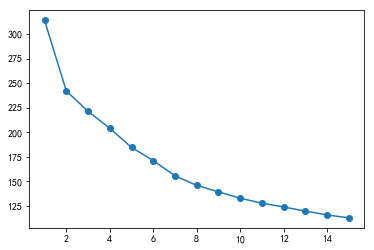

In [164]:
from sklearn.cluster import KMeans

#查看sse值——这不是寻找最优K的最佳指标
#我们先看下图形
sse=[]
for k in range(1,16):
    km=KMeans(n_clusters=k)
    km.fit(data_norm)
    sse.append(km.inertia_)
print('sse:',sse)
plt.plot(range(1,16),sse,marker='o');

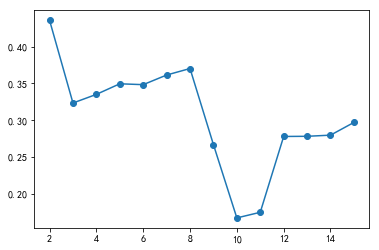

In [165]:
from sklearn.metrics import silhouette_score  #导入轮廓系数计算包

#通过轮廓系数寻找最优的k
score=[]
for k in range(2,16):
    km=KMeans(n_clusters=k)
    res_km=km.fit(data_norm)
    score.append(silhouette_score(data_norm,res_km.labels_))

plt.plot(range(2,16),score,marker='o')

从图形看，K=2模型效果最佳，从业务角度出发，k=2类别划分欠细致；我们排除2再观察其他数据最高点是8，得分也不错，与业务需求相拟合。所以，我们选择的最优K值为8

### 聚类建模

In [166]:
km=KMeans(n_clusters=8)
km.fit(data_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [167]:
km.n_clusters #看分类数

8

In [168]:
km.labels_  #查看分类结果数据

array([1, 1, 1, ..., 1, 1, 1])

In [169]:
#把结果加入user_info5表中
user_info5['类别']=km.labels_
user_info5.head()

,买家会员名,买家实际支付金额,宝贝种类,宝贝总数量,价格,missing,儿童|学生|,婴儿,婴儿幼儿|,婴儿幼儿|儿童|,婴儿幼儿|儿童|学生|,幼儿|,幼儿|儿童|,幼儿|儿童|学生|,类别
0,0,14.90,1.0,1.0,9.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,1,37.56,4.0,8.0,4.957500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1
2,2,58.50,2.0,15.0,3.725000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
3,3,13.39,2.0,2.0,4.520000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
4,4,30.87,6.0,6.0,4.651667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1


## 依据模型划分用户群

### 获取聚类后的用户分类

In [171]:
cluster_result=user_info5.loc[:,['买家会员名','类别']]
cluster_result.head()

,买家会员名,类别
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [172]:
cluster_result.shape,np.unique(cluster_result.买家会员名).shape

((3402, 2), (3402,))

### 导出用户分类结果

In [173]:
if not os.path.exists('save_result'):
    os.makedirs('save_result') #文件夹不存在，创建文件夹

cluster_result.to_csv('save_result/User_Classifier_data.csv',index=False,encoding='GBK')

# 基于用户聚类的结果进行个性化推荐

## 用户没买过的商品信息列表【用户-商品（notbuy）】

In [174]:
total=pd.merge(df_order,df_item,on='订单编号',how='left')
user_item=total.loc[:,['买家会员名','标题']]
#先获取所有发生交易的用户商品信息
user_item['购买次数']=0
user_item_freq=user_item.groupby(['买家会员名','标题']).count().reset_index()
#计算各用户每个商品购买次数
user_item_all=user_item_freq.pivot_table(index='买家会员名',columns='标题',values='购买次数').fillna(0)
#获取用户商品关系矩阵
user_item_all=user_item_all.stack().reset_index()
user_item_all.rename(columns={0:'购买次数'},inplace=True)
user_item_notbuy=user_item_all[user_item_all.购买次数==0].drop('购买次数',axis=1)
user_item_notbuy.head()
#获取用户没有购买其他用户购买的用户商品清单，即用户-商品（notbuy）数据

,买家会员名,标题
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖


## 【用户-商品（notbuy）】匹配用户类群【用户-商品（notbuy）-类群】

In [175]:
user_notbuy_cluster=pd.merge(user_item_notbuy,cluster_result,on='买家会员名',how='left')
#构建用户-商品（notbuy）-类群数据
user_notbuy_cluster.head()

,买家会员名,标题,类别
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,1.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,1.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,1.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,1.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,1.0


## 定义喜欢（用户对商品的购买次数表示喜好度），构建用户对商品的喜好度【用户-商品-喜好度】

In [176]:
user_item_freq.head() #直接使用前面定义过的user_item_freq表即可

,买家会员名,标题,购买次数
0,0,创意电动飞机发光音乐万向车儿童玩具飞机模型拼装 玩具批发地摊,1
1,1,儿童玩具批发卡通小飞机泡泡枪不漏水手动泡泡机户外吹泡泡地摊货,1
2,1,创意新款发光翅膀背带儿童演出服装天使蝴蝶翅膀地摊货源玩具批发,1
3,1,创意新款夏季热卖小象手摇风扇夜市地摊小玩具批发六一儿童节礼物,1
4,1,创意热卖回力惯性小汽车特警先锋 12辆巴士儿童玩具地摊货源批发,1


## 【用户-商品-喜好度】匹配用户类群【用户-商品-喜好度-类群】

In [177]:
user_item_freq_cluster=pd.merge(user_item_freq,cluster_result,on='买家会员名',how='left')
#构建用户-商品-喜好度-类群数据
user_item_freq_cluster.head()

,买家会员名,标题,购买次数,类别
0,0,创意电动飞机发光音乐万向车儿童玩具飞机模型拼装 玩具批发地摊,1,1.0
1,1,儿童玩具批发卡通小飞机泡泡枪不漏水手动泡泡机户外吹泡泡地摊货,1,1.0
2,1,创意新款发光翅膀背带儿童演出服装天使蝴蝶翅膀地摊货源玩具批发,1,1.0
3,1,创意新款夏季热卖小象手摇风扇夜市地摊小玩具批发六一儿童节礼物,1,1.0
4,1,创意热卖回力惯性小汽车特警先锋 12辆巴士儿童玩具地摊货源批发,1,1.0


## 同一类群中的用户对同一种商品的喜好度进行聚合，得到，用户类群对每一个商品的喜好度【类群-商品-平均喜好度】

In [178]:
cluster_item_freq=user_item_freq_cluster.groupby(['类别','标题']).mean()
cluster_item_freq.reset_index(inplace=True)
del cluster_item_freq['买家会员名']
cluster_item_freq.head()
#构建类群-商品-平均喜好度数据

,类别,标题,购买次数
0,0.0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,1.2
1,0.0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,1.0
2,0.0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,1.0
3,0.0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,1.0
4,0.0,2017创意新款惯性工程车 槽罐水泥车汽车男生礼物儿童玩具车批发,1.0


## 将user_notbuy_cluster与cluster_item_freq进行合并，得到【用户-商品（notbuy）-类群-类群平均喜好度】

In [179]:
res=pd.merge(user_notbuy_cluster,cluster_item_freq,
             on=['标题','类别'],how='left').fillna(0)

res.head()
#构建用户-商品（notbuy）-类群-类群平均喜好度数据

,买家会员名,标题,类别,购买次数
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,1.0,1.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,1.0,1.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,1.0,1.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,1.0,1.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,1.0,1.0


## 对用户进行分组排序，推荐

In [180]:
k=5  #先设定top值
topk=res.groupby('买家会员名').apply(lambda x:x.sort_values('购买次数',
                                                       ascending=False)[:k]).drop(columns='买家会员名',axis=1)
topk=topk.reset_index().drop(columns='level_1',axis=1)
topk.rename(columns={'购买次数':'推荐指数'},inplace=True)
topk.head(20)
#获得用户前n推荐清单

,买家会员名,标题,类别,推荐指数
0,0,特价发条玩具会跑会跳创意上链发条玩具动物儿童好玩的地摊货批,1.0,4.250000
1,0,六一新品恐龙玩具模型回力小车迷你玩具车儿童节礼物地摊货源批,1.0,4.000000
2,0,过家家厨房玩具仿真小家电电动热卖单只装迷你儿童玩具女孩童创意,1.0,3.111111
3,0,六一新品恐龙玩具模型回力小车迷你玩具车儿童节礼物地摊货源批发,1.0,2.884615
4,0,经典发条玩具会跑会跳创意上链发条玩具动物儿童好玩的地摊货批发,1.0,2.666667
5,1,特价发条玩具会跑会跳创意上链发条玩具动物儿童好玩的地摊货批,1.0,4.250000
6,1,六一新品恐龙玩具模型回力小车迷你玩具车儿童节礼物地摊货源批,1.0,4.000000
7,1,过家家厨房玩具仿真小家电电动热卖单只装迷你儿童玩具女孩童创意,1.0,3.111111
8,1,六一新品恐龙玩具模型回力小车迷你玩具车儿童节礼物地摊货源批发,1.0,2.884615
9,1,经典发条玩具会跑会跳创意上链发条玩具动物儿童好玩的地摊货批发,1.0,2.666667


# 导出最终结果

In [181]:
if not os.path.exists('save_result'):
    os.makedirs('save_result') #文件夹不存在，创建文件夹

topk.to_csv('save_result/Cluster_User_Item_Topn_data.csv',index=False,encoding='GBK')